In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
data_folder = "D:/korean-single-speaker-speech-dataset/kss"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [3]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [4]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [5]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [6]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output

In [7]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

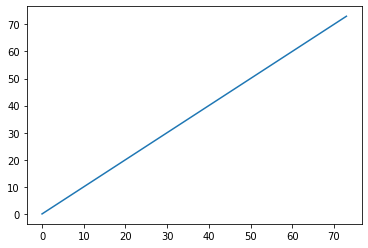

In [8]:
plt.plot(jamo_tokens)
plt.show()

In [9]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [10]:
# embedding_layer = nn.Embedding(len(jamo_tokens), 256)

# print(metadata[5031, 3])
# print(metadata[5031, 2])
# print(len(metadata[5031, 3]))

# input_token = tokenizer.word2num(metadata[5031, 3])
# input_tensor = torch.tensor(input_token)
# plt.imshow(embedding_layer(input_tensor).detach().numpy())

In [11]:
class Encoder(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.H = H
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        
        self.fc_2 = torch.nn.Linear(H, H)
        self.relu_2 = torch.nn.ReLU()
        
        self.gru = nn.GRU(H, D_out, num_layers=3, bidirectional=True, batch_first=True)
        self.relu_gru = torch.nn.ReLU()

    def forward(self, input_tensor):
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        output_tensor = self.relu_gru(output_tensor)
        
        output_tensor = self.fc_2(output_tensor)
        output_tensor = self.relu_2(output_tensor)
        return output_tensor
    
class Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(Decoder, self).__init__()
        self.H = H
        self.fc_embed = nn.Linear(256, 1024)
        self.gru = nn.GRU(2 * H, H, batch_first=True)
        self.attention = AttentionModule(D_out * 2)
        self.fc = nn.Linear(1024, 74)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, input_tensor, hidden_tensor, query):
#         print("Input tensor shape in Decoder: {}".format(input_tensor.shape))
#         print("Hidden_tensor shape in Decoder: {}".format(hidden_tensor.shape))
        output_tensor = self.fc_embed(input_tensor)
#         print("Output tensor shape in Decoder: {}".format(output_tensor.shape))
        output_tensor, hidden_tensor = self.gru(output_tensor, hidden_tensor)
        
#         print("Hidden_tensor shape in Decoder: {}".format(hidden_tensor.shape))
#         print("Output tensor shape in Decoder: {}".format(output_tensor.shape))
        
        context_vector, alpha = self.attention(query, output_tensor)
        output_tensor = torch.cat([output_tensor, context_vector], dim=2)
#         print('output_tensor: {}'.format(output_tensor.shape))
#         print('output_tensor: {}'.format(context_vector.shape))
        output_tensor = self.fc(output_tensor)
        prediction_tensor = self.softmax(output_tensor)

        return prediction_tensor, hidden_tensor, context_vector, alpha

class AttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(AttentionModule, self).__init__()
        self.fc_alpha = nn.Linear(H, 1)
        self.W = nn.Linear(H, H)
        self.V = nn.Linear(H, H)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
        output_tensor = torch.tanh(torch.add(self.W(query), self.V(key)))
        e = self.fc_alpha(output_tensor)
        e_sig = self.sigmoid(e)
        alpha = self.softmax(e_sig).transpose(1, 2)
        context_vector = torch.bmm(alpha, query)
        
        return context_vector, alpha

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        self.encoder = Encoder(D_in, H, D_out).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = Decoder(H, D_out).to(device)
        self.encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=0.01)
        self.decoder_optimizer = optim.SGD(self.decoder.parameters(), lr=0.01)
        self.embedding_optimizer = optim.SGD(self.embedding_layer.parameters(), lr=0.01)
        
        self.criterion = nn.CrossEntropyLoss(reduction='none')

    def train(self, input_tensor, ground_truth, loss_mask):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)
        decoder_hidden = encoded_tensor[:, -1, :].view(1, batch_size, self.H).contiguous()
#         decoder_hidden = encoded_tensor[:, -1, :].transpose(0, 1)
        
        pred_tensor_list = list()
        att_weight_list = list()
        
        loss = 0
        
        decoder_input = self.embedding_layer(torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).to(device)).view([batch_size, 1, -1])
        
#         print(encoded_tensor.shape)
#         print(decoder_hidden.shape)
#         print(decoder_input.shape)
        
        for i in range(ground_truth.shape[1]):
            
            pred_tensor, decoder_hidden, context_vector, att_weight = self.decoder(decoder_input, decoder_hidden, encoded_tensor)
            pred_tensor_list.append(pred_tensor)
            att_weight_list.append(att_weight)
            
#             print('pred_tensor shape: {}'.format(pred_tensor.shape))
            truth = ground_truth[:, i]
            truth = truth.type(torch.cuda.LongTensor)
            
            loss += torch.dot(loss_mask[:, i], self.criterion(pred_tensor.view([batch_size, -1]), truth)) / batch_size
            decoder_input = self.embedding_layer(truth).view([batch_size, 1, -1])
            
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()

        pred_tensor = torch.cat(pred_tensor_list, dim=1)
        attention_matrix = torch.cat(att_weight_list, dim=1)
        
        return pred_tensor, attention_matrix, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
    
net = Mel2SeqNet(80, 512, 256)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [13]:
# class Preloader():
#     def __init__(self, mel_path_list):
#         super(Preloader).__init__()
#         self.mel_path_list = mel_path_list
#         self.tensor_input_list = [None] * len(mel_path_list)
    
#     def load(self, i):
#         norm_log_mel_specgram = np.load(self.mel_path_list[i])
#         input_spectrogram = norm_log_mel_specgram.T
#         tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
#         self.tensor_input_list[i] = tensor_input
        
#     def get(self, i):
#         if type(self.tensor_input_list[i]) == type(None):
#             self.load(i)
#         return self.tensor_input_list[i]  
    
#     def get_batch(self):
        
#         return batched_tensor, indxes 

In [14]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 4
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        
        for order in range(count):
            batched_tensor[order, :tensor_size_list[order], :] = tensor_list[order]
#             print(ground_truth_size_list[order])
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask
        
#         return batched_tensor, ground_truth_tensor 

In [15]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [16]:
# preloader = Preloader(mel_path_list)
preloader = Batched_Preloader(mel_path_list, ground_truth_list, 32)

08-24 22:59:16
Calculated 100 Batches
Loss 100: 3.773083448410034
08-24 22:59:51


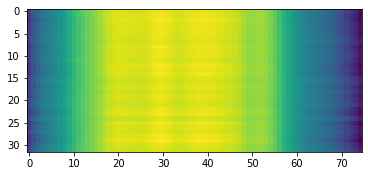

Calculated 200 Batches
Loss 200: 3.8659923553466795
08-24 23:00:34


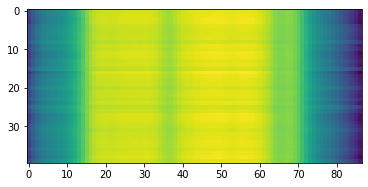

Calculated 300 Batches
Loss 300: 3.8549184799194336
08-24 23:01:22


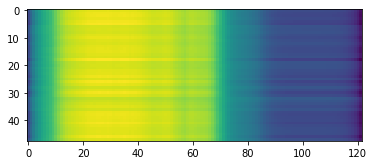

Calculated 400 Batches
Loss 400: 3.7817684520374644
08-24 23:02:18


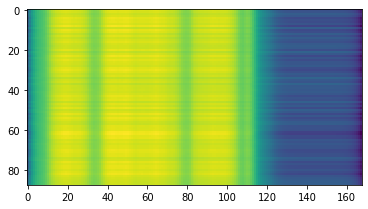

Mean Loss: 3.815572376212487
----------------------------------------------------
08-24 23:02:19
Calculated 100 Batches
Loss 100: 3.8148908615112305
08-24 23:02:39


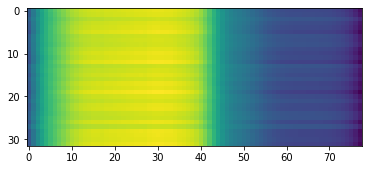

Calculated 200 Batches
Loss 200: 3.8230682373046876
08-24 23:03:05


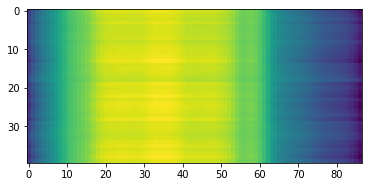

Calculated 300 Batches
Loss 300: 3.8399508794148765
08-24 23:03:37


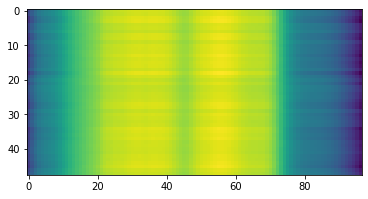

Calculated 400 Batches
Loss 400: 3.794963836669922
08-24 23:04:18


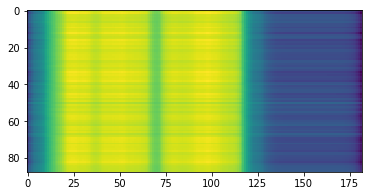

Mean Loss: 3.815368501743852
----------------------------------------------------
08-24 23:04:20
Calculated 100 Batches
Loss 100: 3.7347898483276367
08-24 23:04:39


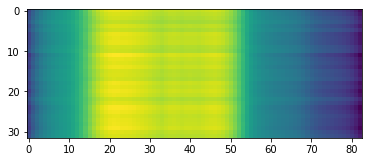

Calculated 200 Batches
Loss 200: 3.808303451538086
08-24 23:05:06


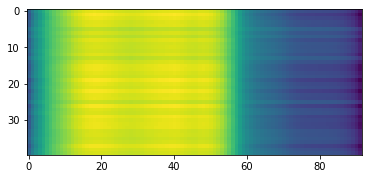

Calculated 300 Batches
Loss 300: 3.8300902048746743
08-24 23:05:38


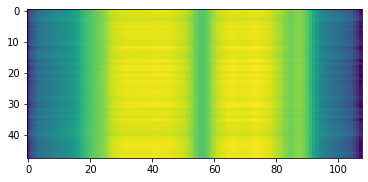

Calculated 400 Batches
Loss 400: 3.783871390602805
08-24 23:06:18


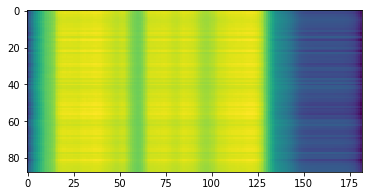

Mean Loss: 3.8151279247338357
----------------------------------------------------
08-24 23:06:20
Calculated 100 Batches
Loss 100: 3.779475450515747
08-24 23:06:39


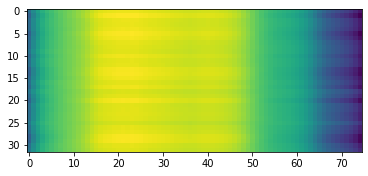

Calculated 200 Batches
Loss 200: 3.813314437866211
08-24 23:07:05


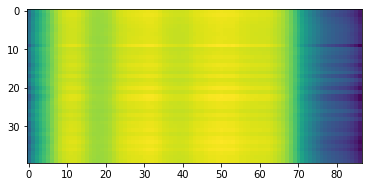

Calculated 300 Batches
Loss 300: 3.8616968790690103
08-24 23:07:37


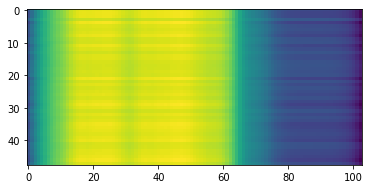

Calculated 400 Batches
Loss 400: 3.7840503345836294
08-24 23:08:18


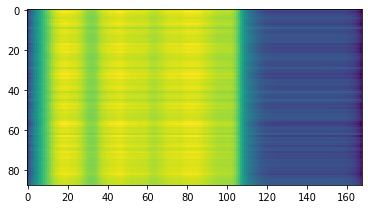

Mean Loss: 3.815281160457123
----------------------------------------------------
08-24 23:08:19
Calculated 100 Batches
Loss 100: 3.8111753463745117
08-24 23:08:39


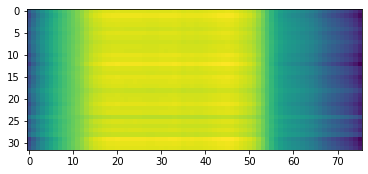

Calculated 200 Batches
Loss 200: 3.824323272705078
08-24 23:09:06


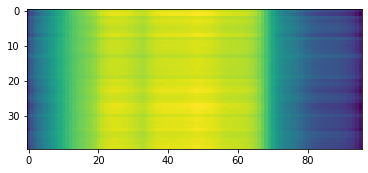

Calculated 300 Batches
Loss 300: 3.8111867904663086
08-24 23:09:37


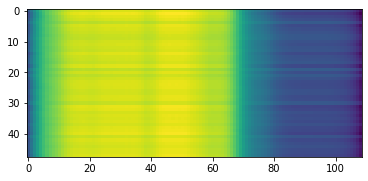

Calculated 400 Batches
Loss 400: 3.7810901295055044
08-24 23:10:15


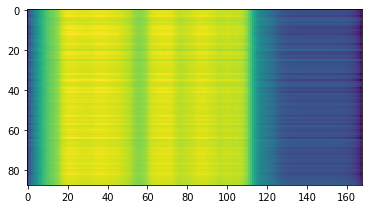

Mean Loss: 3.8157850497704024
----------------------------------------------------
08-24 23:10:17
Calculated 100 Batches
Loss 100: 3.8084511756896973
08-24 23:10:35


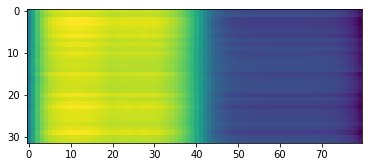

Calculated 200 Batches
Loss 200: 3.820138931274414
08-24 23:11:01


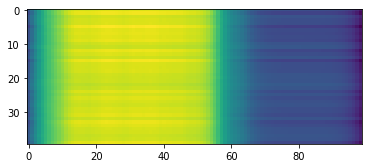

Calculated 300 Batches
Loss 300: 3.8587118784586587
08-24 23:11:33


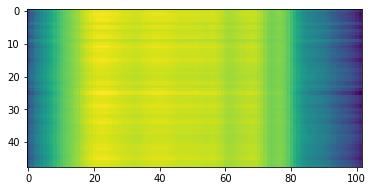

Calculated 400 Batches
Loss 400: 3.7913495844060723
08-24 23:12:13


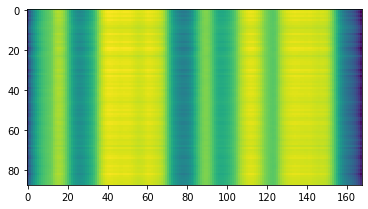

Mean Loss: 3.8150218388506394
----------------------------------------------------
08-24 23:12:15
Calculated 100 Batches
Loss 100: 3.8528366088867188
08-24 23:12:33


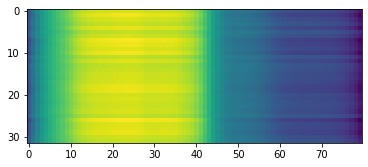

Calculated 200 Batches
Loss 200: 3.872118377685547
08-24 23:13:00


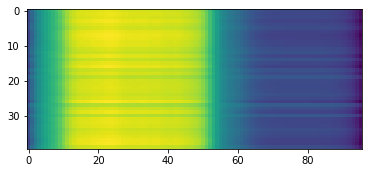

Calculated 300 Batches
Loss 300: 3.8608363469441733
08-24 23:13:31


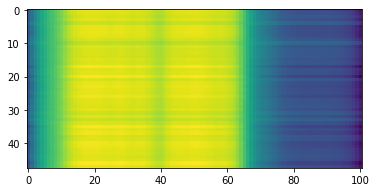

Calculated 400 Batches
Loss 400: 3.7886394153941763
08-24 23:14:11


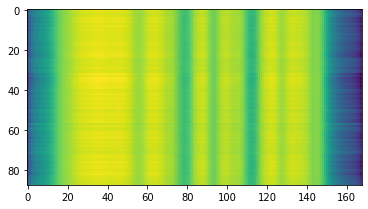

Mean Loss: 3.814898922606916
----------------------------------------------------
08-24 23:14:12
Calculated 100 Batches
Loss 100: 3.8069891929626465
08-24 23:14:30


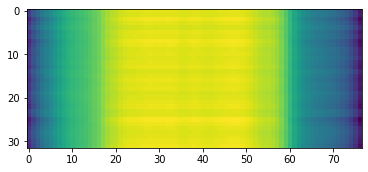

Calculated 200 Batches
Loss 200: 3.7957035064697267
08-24 23:14:57


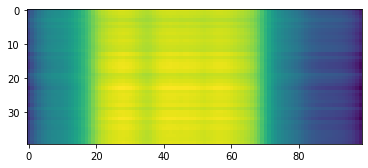

Calculated 300 Batches
Loss 300: 3.8520803451538086
08-24 23:15:29


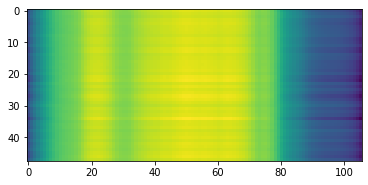

Calculated 400 Batches
Loss 400: 3.7910246415571733
08-24 23:16:09


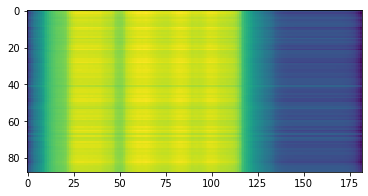

Mean Loss: 3.8155561443080903
----------------------------------------------------
08-24 23:16:11
Calculated 100 Batches
Loss 100: 3.8247480392456055
08-24 23:16:29


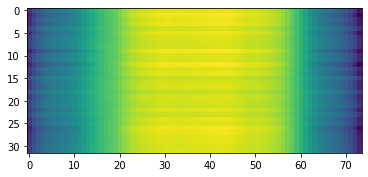

Calculated 200 Batches
Loss 200: 3.814817428588867
08-24 23:16:56


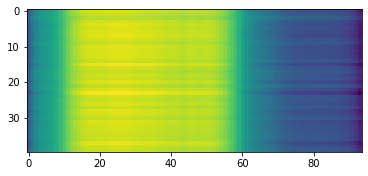

Calculated 300 Batches
Loss 300: 3.857459386189779
08-24 23:17:28


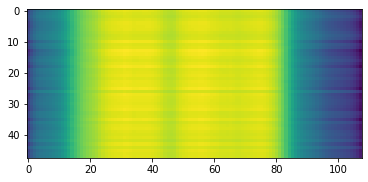

Calculated 400 Batches
Loss 400: 3.7800743796608667
08-24 23:18:08


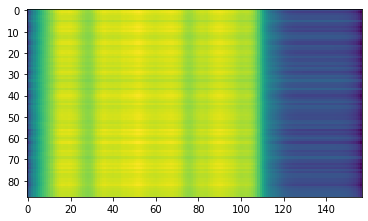

Mean Loss: 3.8157373828748904
----------------------------------------------------
08-24 23:18:10
Calculated 100 Batches
Loss 100: 3.823063373565674
08-24 23:18:29


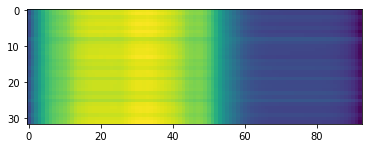

Calculated 200 Batches
Loss 200: 3.800572967529297
08-24 23:18:55


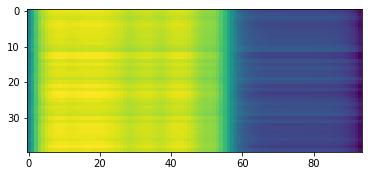

Calculated 300 Batches
Loss 300: 3.864713986714681
08-24 23:19:27


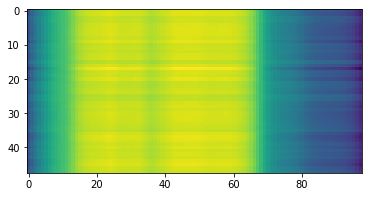

Calculated 400 Batches
Loss 400: 3.7911501797762783
08-24 23:20:08


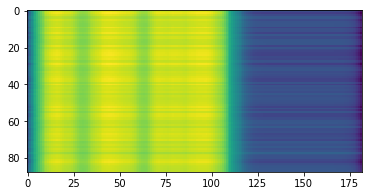

Mean Loss: 3.8148109805564263
----------------------------------------------------
08-24 23:20:09
Calculated 100 Batches
Loss 100: 3.8137519359588623
08-24 23:20:29


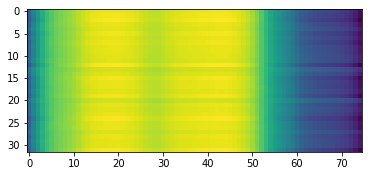

Calculated 200 Batches
Loss 200: 3.8197200775146483
08-24 23:20:55


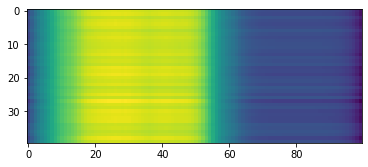

Calculated 300 Batches
Loss 300: 3.873996098836263
08-24 23:21:27


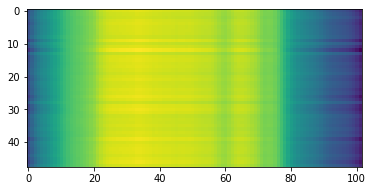

Calculated 400 Batches
Loss 400: 3.7866287231445312
08-24 23:22:07


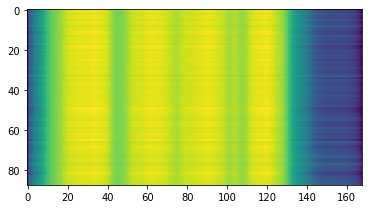

Mean Loss: 3.8148411213022393
----------------------------------------------------
08-24 23:22:09
Calculated 100 Batches
Loss 100: 3.837146759033203
08-24 23:22:28


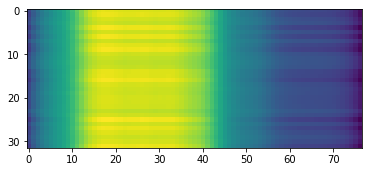

Calculated 200 Batches
Loss 200: 3.8237445831298826
08-24 23:22:54


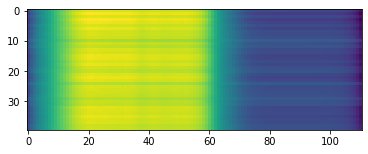

Calculated 300 Batches
Loss 300: 3.860187212626139
08-24 23:23:26


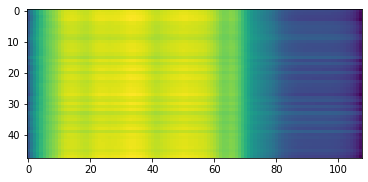

Calculated 400 Batches
Loss 400: 3.7833643826571377
08-24 23:24:06


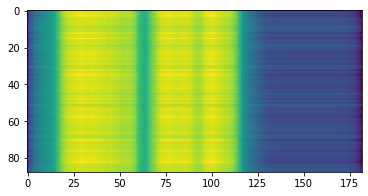

Mean Loss: 3.8144151741031562
----------------------------------------------------
08-24 23:24:08
Calculated 100 Batches
Loss 100: 3.8140854835510254
08-24 23:24:27


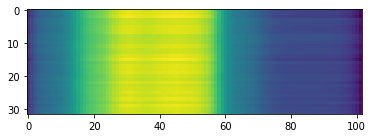

Calculated 200 Batches
Loss 200: 3.839175796508789
08-24 23:24:53


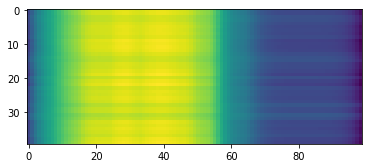

Calculated 300 Batches
Loss 300: 3.8675626118977866
08-24 23:25:25


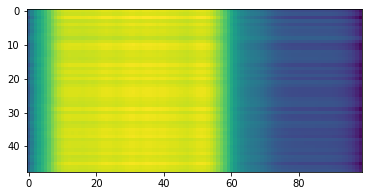

Calculated 400 Batches
Loss 400: 3.7826017899946733
08-24 23:26:06


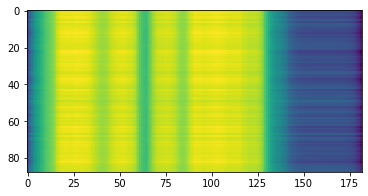

Mean Loss: 3.8139207581282517
----------------------------------------------------
08-24 23:26:07
Calculated 100 Batches
Loss 100: 3.8325414657592773
08-24 23:26:27


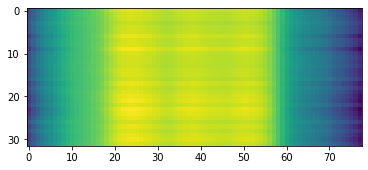

Calculated 200 Batches
Loss 200: 3.8434478759765627
08-24 23:26:53


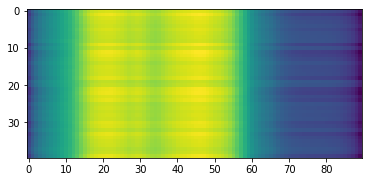

Calculated 300 Batches
Loss 300: 3.8449014027913413
08-24 23:27:25


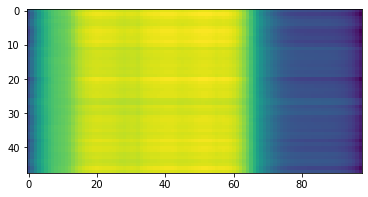

Calculated 400 Batches
Loss 400: 3.7915912974964487
08-24 23:28:05


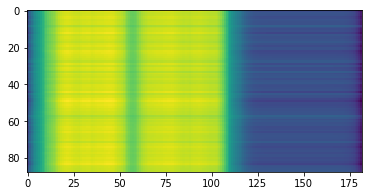

Mean Loss: 3.813795949857512
----------------------------------------------------
08-24 23:28:07
Calculated 100 Batches
Loss 100: 3.813054084777832
08-24 23:28:25


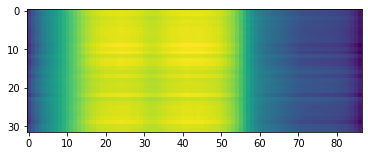

Calculated 200 Batches
Loss 200: 3.8130043029785154
08-24 23:28:52


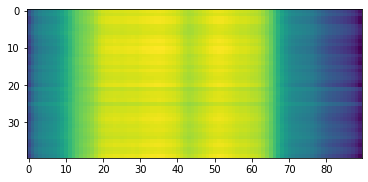

Calculated 300 Batches
Loss 300: 3.852575937906901
08-24 23:29:23


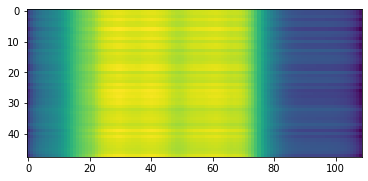

Calculated 400 Batches
Loss 400: 3.788760792125355
08-24 23:30:03


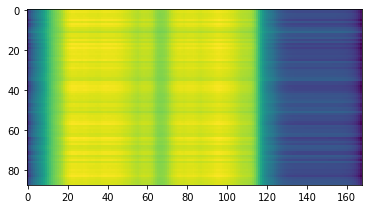

Mean Loss: 3.8134744788811834
----------------------------------------------------
08-24 23:30:04
Calculated 100 Batches
Loss 100: 3.7720415592193604
08-24 23:30:23


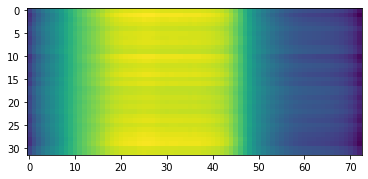

Calculated 200 Batches
Loss 200: 3.8243980407714844
08-24 23:30:50


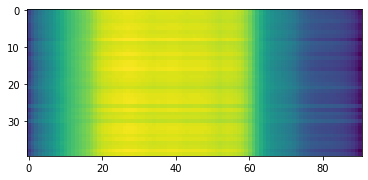

Calculated 300 Batches
Loss 300: 3.8623634974161782
08-24 23:31:21


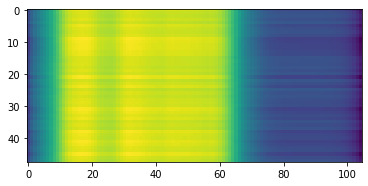

Calculated 400 Batches
Loss 400: 3.775442296808416
08-24 23:32:01


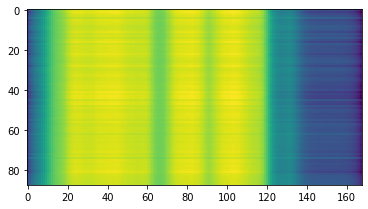

Mean Loss: 3.8133092559034223
----------------------------------------------------
08-24 23:32:02
Calculated 100 Batches
Loss 100: 3.8158209323883057
08-24 23:32:22


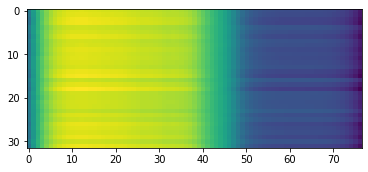

Calculated 200 Batches
Loss 200: 3.81164665222168
08-24 23:32:48


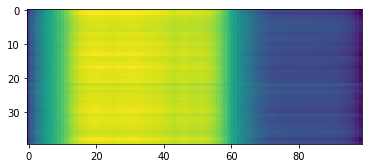

Calculated 300 Batches
Loss 300: 3.854916572570801
08-24 23:33:20


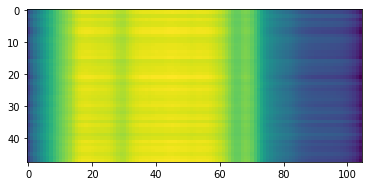

Calculated 400 Batches
Loss 400: 3.780323722145774
08-24 23:34:00


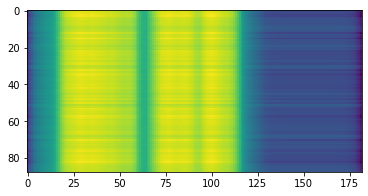

Mean Loss: 3.8132007642505967
----------------------------------------------------
08-24 23:34:01
Calculated 100 Batches
Loss 100: 3.800095796585083
08-24 23:34:20


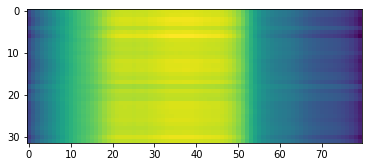

Calculated 200 Batches
Loss 200: 3.832305908203125
08-24 23:34:47


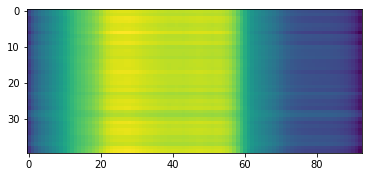

Calculated 300 Batches
Loss 300: 3.8377183278401694
08-24 23:35:19


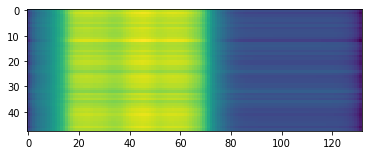

Calculated 400 Batches
Loss 400: 3.7848902615633877
08-24 23:35:58


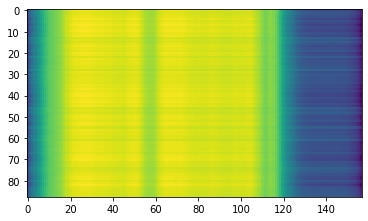

Mean Loss: 3.813303368020461
----------------------------------------------------
08-24 23:35:59
Calculated 100 Batches
Loss 100: 3.8760571479797363
08-24 23:36:19


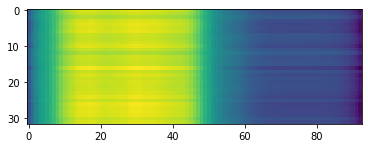

Calculated 200 Batches
Loss 200: 3.8743091583251954
08-24 23:36:45


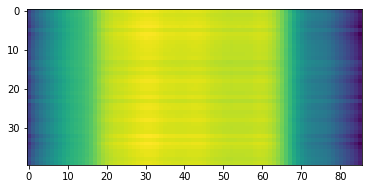

Calculated 300 Batches
Loss 300: 3.863096237182617
08-24 23:37:16


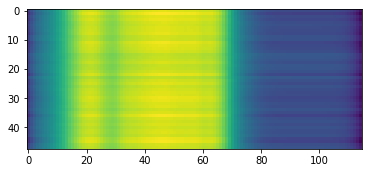

Calculated 400 Batches
Loss 400: 3.825304404072378
08-24 23:37:55


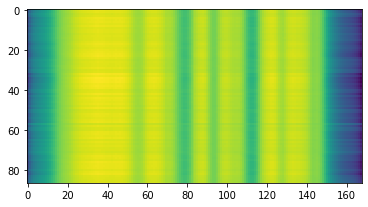

Mean Loss: 3.813138961863675
----------------------------------------------------
08-24 23:37:57
Calculated 100 Batches
Loss 100: 3.8194334506988525
08-24 23:38:16


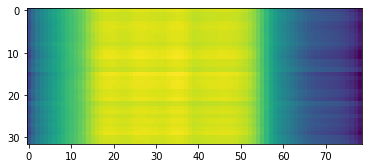

Calculated 200 Batches
Loss 200: 3.8451168060302736
08-24 23:38:43


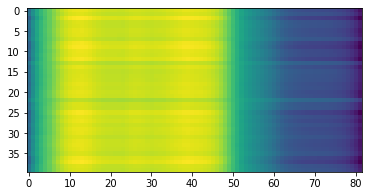

Calculated 300 Batches
Loss 300: 3.868356704711914
08-24 23:39:14


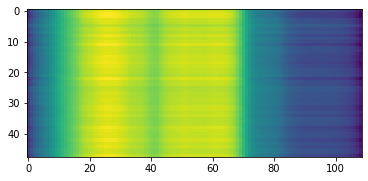

Calculated 400 Batches
Loss 400: 3.7802845348011362
08-24 23:39:53


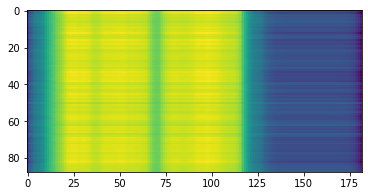

Mean Loss: 3.8126397437892336
----------------------------------------------------
08-24 23:39:55
Calculated 100 Batches
Loss 100: 3.824370861053467
08-24 23:40:14


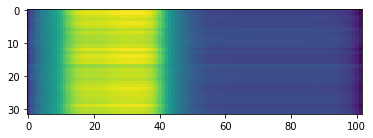

Calculated 200 Batches
Loss 200: 3.791411209106445
08-24 23:40:41


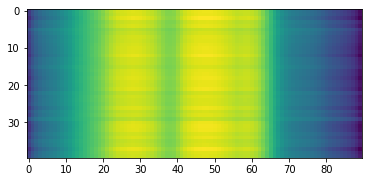

Calculated 300 Batches
Loss 300: 3.84346071879069
08-24 23:41:12


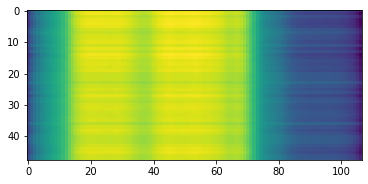

Calculated 400 Batches
Loss 400: 3.7745690779252485
08-24 23:41:52


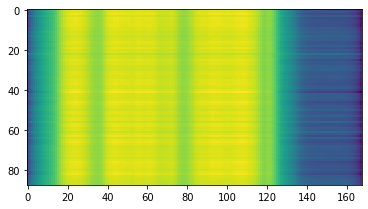

Mean Loss: 3.8125375934749
----------------------------------------------------
08-24 23:41:53
Calculated 100 Batches
Loss 100: 3.794282913208008
08-24 23:42:13


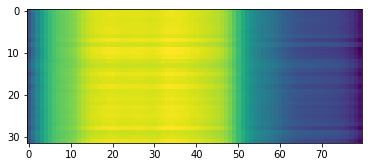

Calculated 200 Batches
Loss 200: 3.823790740966797
08-24 23:42:39


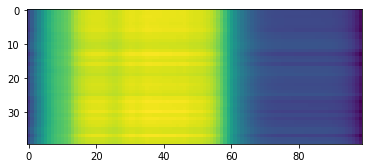

Calculated 300 Batches
Loss 300: 3.849916458129883
08-24 23:43:10


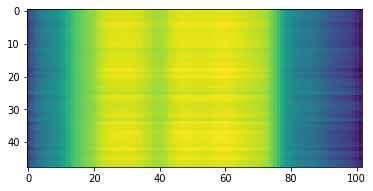

Calculated 400 Batches
Loss 400: 3.7769286415793677
08-24 23:43:50


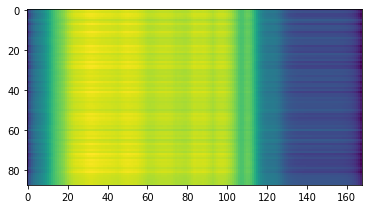

Mean Loss: 3.812464949892354
----------------------------------------------------
08-24 23:43:51
Calculated 100 Batches
Loss 100: 3.8287413120269775
08-24 23:44:10


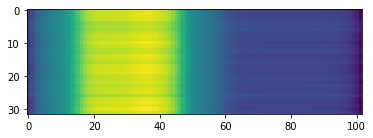

Calculated 200 Batches
Loss 200: 3.823831558227539
08-24 23:44:36


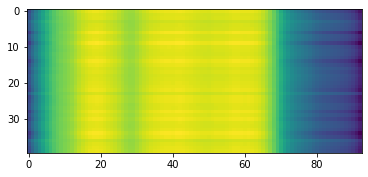

Calculated 300 Batches
Loss 300: 3.859145164489746
08-24 23:45:07


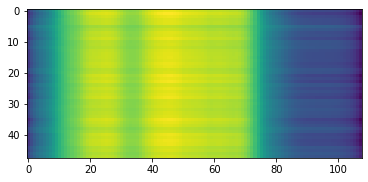

Calculated 400 Batches
Loss 400: 3.776468103582209
08-24 23:45:47


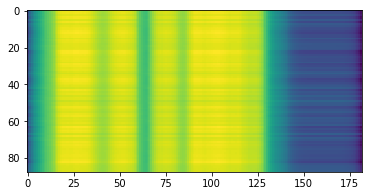

Mean Loss: 3.8122454022548227
----------------------------------------------------
08-24 23:45:48
Calculated 100 Batches
Loss 100: 3.832745313644409
08-24 23:46:08


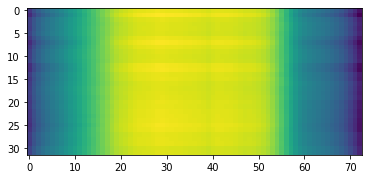

Calculated 200 Batches
Loss 200: 3.8108856201171877
08-24 23:46:34


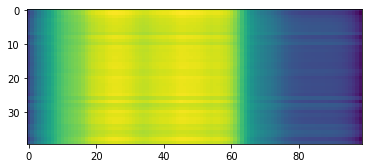

Calculated 300 Batches
Loss 300: 3.8641061782836914
08-24 23:47:05


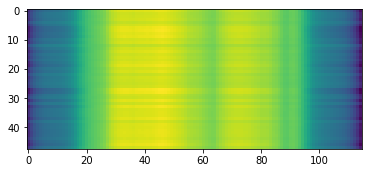

Calculated 400 Batches
Loss 400: 3.7744314020330254
08-24 23:47:45


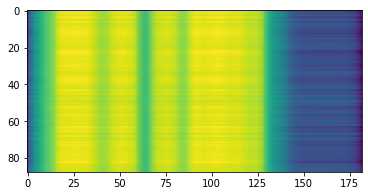

Mean Loss: 3.812156341045494
----------------------------------------------------
08-24 23:47:47
Calculated 100 Batches
Loss 100: 3.8220784664154053
08-24 23:48:06


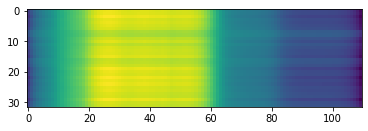

Calculated 200 Batches
Loss 200: 3.843039703369141
08-24 23:48:33


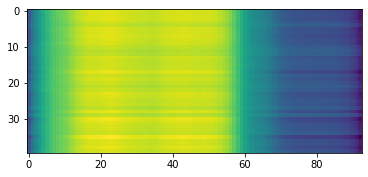

Calculated 300 Batches
Loss 300: 3.8715569178263345
08-24 23:49:04


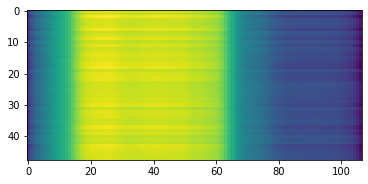

Calculated 400 Batches
Loss 400: 3.77419731833718
08-24 23:49:43


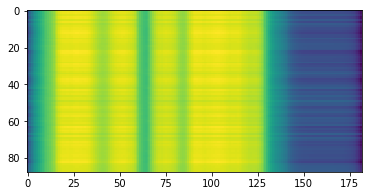

Mean Loss: 3.8123510831818765
----------------------------------------------------
08-24 23:49:44
Calculated 100 Batches
Loss 100: 3.80605411529541
08-24 23:50:03


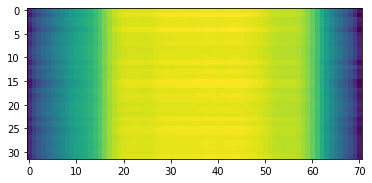

Calculated 200 Batches
Loss 200: 3.8157894134521486
08-24 23:50:30


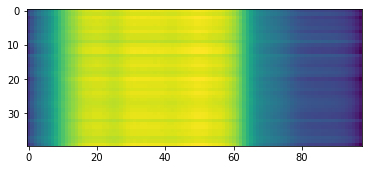

Calculated 300 Batches
Loss 300: 3.8659537633260093
08-24 23:51:02


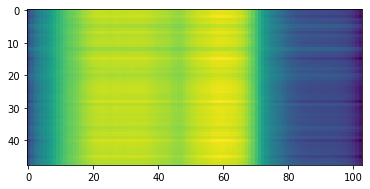

Calculated 400 Batches
Loss 400: 3.7822265625
08-24 23:51:41


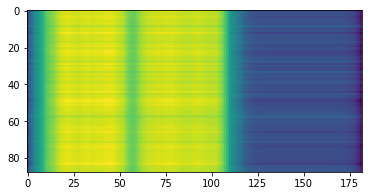

Mean Loss: 3.8121567643862595
----------------------------------------------------
08-24 23:51:42
Calculated 100 Batches
Loss 100: 3.837505578994751
08-24 23:52:02


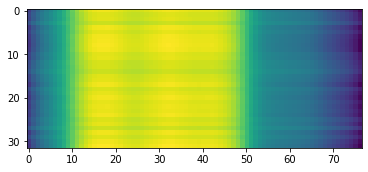

Calculated 200 Batches
Loss 200: 3.876557159423828
08-24 23:52:28


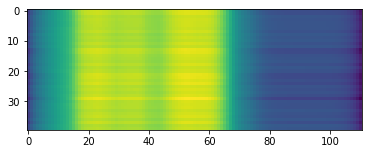

Calculated 300 Batches
Loss 300: 3.8862622578938804
08-24 23:52:59


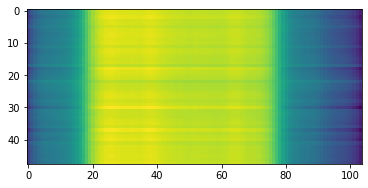

Calculated 400 Batches
Loss 400: 3.7848989313299004
08-24 23:53:39


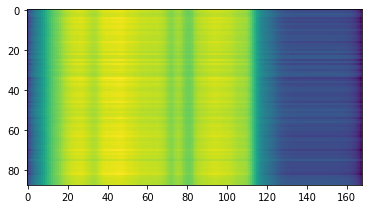

Mean Loss: 3.8124860783681083
----------------------------------------------------
08-24 23:53:41
Calculated 100 Batches
Loss 100: 3.8393914699554443
08-24 23:53:59


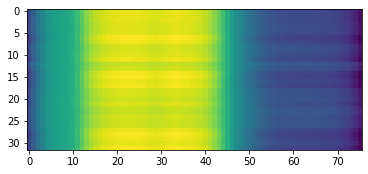

Calculated 200 Batches
Loss 200: 3.8500614166259766
08-24 23:54:25


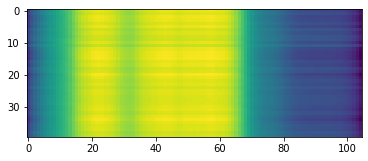

Calculated 300 Batches
Loss 300: 3.8508472442626953
08-24 23:54:57


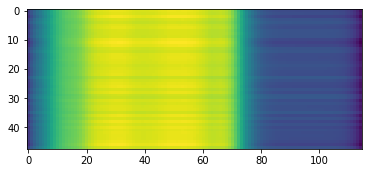

Calculated 400 Batches
Loss 400: 3.78477651422674
08-24 23:55:37


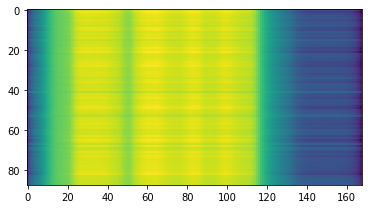

Mean Loss: 3.8116971187692448
----------------------------------------------------
08-24 23:55:38
Calculated 100 Batches
Loss 100: 3.827341079711914
08-24 23:55:57


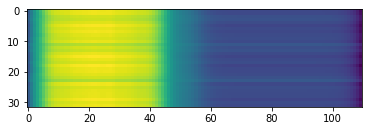

Calculated 200 Batches
Loss 200: 3.855124282836914
08-24 23:56:23


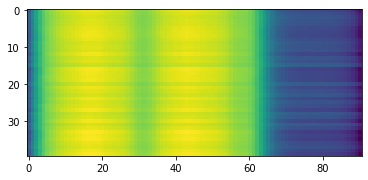

Calculated 300 Batches
Loss 300: 3.8743518193562827
08-24 23:56:54


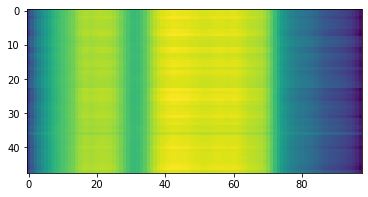

Calculated 400 Batches
Loss 400: 3.782573699951172
08-24 23:57:34


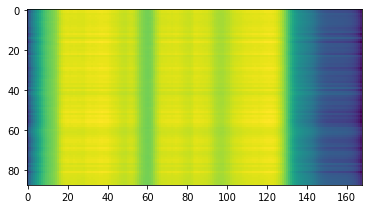

Mean Loss: 3.8117957252249948
----------------------------------------------------
08-24 23:57:35
Calculated 100 Batches
Loss 100: 3.773696184158325
08-24 23:57:54


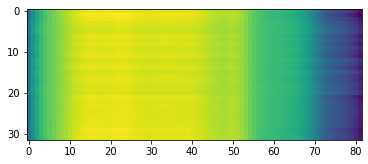

Calculated 200 Batches
Loss 200: 3.838471221923828
08-24 23:58:20


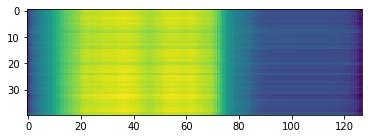

Calculated 300 Batches
Loss 300: 3.8720340728759766
08-24 23:58:52


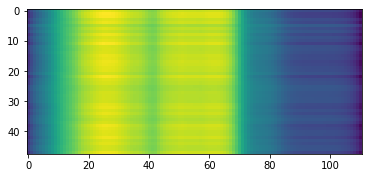

Calculated 400 Batches
Loss 400: 3.7809906005859375
08-24 23:59:31


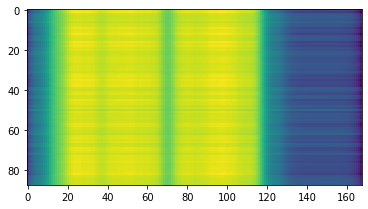

Mean Loss: 3.8111182810208737
----------------------------------------------------


In [17]:
EPOCH = 30

for epoch in range(EPOCH):
    net.load('check_point_test')
    preloader.initialize_batch()
    counter = 0
    loss_list = list()
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    while preloader.end_flag == False:
        tensor_input, ground_truth, loss_mask = preloader.get_batch()
        pred_tensor, attention_matrix, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device))
        
        counter += 1
        loss_list.append(loss)
        
        if (counter % 100 == 0):
            print('Calculated {} Batches'.format(counter))
            print('Loss {}: {}'.format(counter, loss))
            print(datetime.now().strftime('%m-%d %H:%M:%S'))

            plt.figure()
            plt.imshow(attention_matrix[0].detach().cpu().numpy())
#             plt.colorbar()
            plt.show()
#             _, index = pred_tensor.max(-1)
#             sentence = tokenizer.num2word(index.view(-1))
#             print(''.join(sentence))
#             print(ground_truth[0, :])
            
    net.save('check_point_test')
    print("Mean Loss: {}".format(np.mean(np.asarray(loss_list))))
    print("----------------------------------------------------")

In [ ]:
EPOCH = 1

for epoch in range(EPOCH):
    
    net.load('check_point_test')
    
    for i in tqdm(range(len(metadata))):
        tensor_input = preloader.get(i)
        ground_truth = ground_truth_list[i]
        
        pred_tensor, attention_matrix, loss = net.train(tensor_input.to(device), ground_truth.to(device))
        
        if (i % 100 == 0):
            print(datetime.datetime.now())
            print('Loss {}: {}'.format(i, loss))
            plt.figure()
            plt.imshow(attention_matrix[0].detach().cpu().numpy())
            plt.colorbar()
            plt.show()
            _, index = pred_tensor.max(-1)
            sentence = tokenizer.num2word(index.view(-1))
            print(''.join(sentence))
            print(metadata[i, 2])
    
    net.save('check_point_test')

In [ ]:
plt.figure()
plt.imshow(attention_matrix[0].detach().cpu().numpy())
plt.colorbar()
plt.show()

In [ ]:
print(attention_matrix[0, 0, :].shape)
print(sum(attention_matrix[0, 0, :]))

In [ ]:
net.save('check_point_test')

In [ ]:
net.load('check_point_test')